In [14]:
import sys
sys.path.append('/home/gddaslab/mxp140/ca_signaling_surrogate_model')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ode import ode, analytical_solution
from scipy.integrate import solve_ivp

/tmp/ipykernel_3376110/4061768819.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


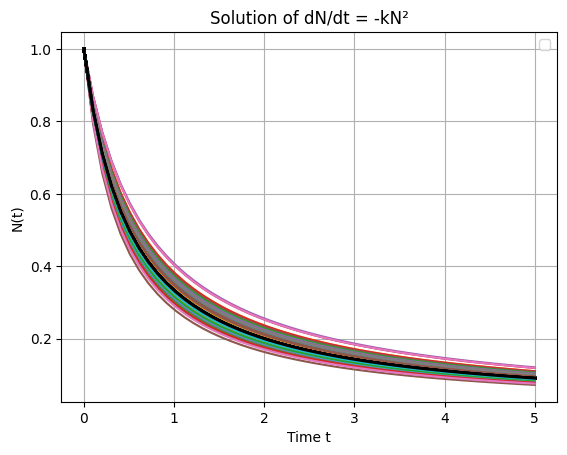

In [4]:
# Parameters
k_mu = 2
k_std = 0.2
num_samples = 100
# Generate samples
k_samples = np.random.normal(loc=k_mu, scale=k_std, size=num_samples)
N0 = 1

# Time span and evaluation points
t_span = (0, 5)
total_time_points = 50
t_eval = np.linspace(*t_span, total_time_points)

all_solution = np.zeros((len(k_samples), total_time_points))
for i, k in enumerate(k_samples):
    all_solution[i] = analytical_solution(t_eval, N0, k)
    plt.plot(t_eval, analytical_solution(t_eval, N0, k))
    plt.plot(t_eval, analytical_solution(t_eval, N0, k_mu), color='black', linewidth=2)
plt.xlabel('Time t')
plt.ylabel('N(t)')
plt.title('Solution of dN/dt = -kN²')
plt.grid()
plt.legend()
plt.show()

/tmp/ipykernel_3376110/2602670979.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


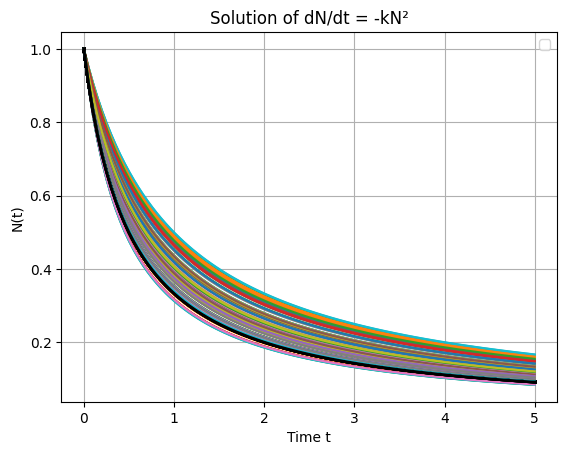

In [8]:
# Parameters
k_mu = 2
k_std = 0.2
num_samples = 100
# Generate samples
k_samples = np.random.uniform(low=k_mu-5*k_std, high=k_mu+0.2, size=num_samples)
N0 = 1

# Time span and evaluation points
t_span = (0, 5)
t_eval = np.linspace(*t_span, 100)

all_solution = np.zeros((len(k_samples), 100))
for i, k in enumerate(k_samples):
    all_solution[i] = analytical_solution(t_eval, N0, k)
    plt.plot(t_eval, analytical_solution(t_eval, N0, k))
    plt.plot(t_eval, analytical_solution(t_eval, N0, k_mu), color='black', linewidth=2)
plt.xlabel('Time t')
plt.ylabel('N(t)')
plt.title('Solution of dN/dt = -kN²')
plt.grid()
plt.legend()
plt.show()

In [18]:
import torch
import pickle
from models import GRUModel

In [16]:
NUM_FEATURES = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
input_dim = NUM_FEATURES
hidden_dim = 128
output_dim = 1
num_layers = 1  # number of GRU layers
dropout = (
    0.1 if num_layers > 1 else 0.0
)  # dropout probability is the same for all layers regressors
bidirectional = False

model = GRUModel(
    input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout
).to(device)
state_dict = torch.load(
    "toy_model_improper.pth", map_location="cpu", weights_only=True
)
remove_prefix = "_orig_mod."
state_dict = {
    k[len(remove_prefix) :] if k.startswith(remove_prefix) else k: v
    for k, v in state_dict.items()
}
model.load_state_dict(state_dict)
model.eval()

GRUModel(
  (gru): GRU(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [52]:
# ----------------------------
#      LOAD NORMALIZATION STATS
# ----------------------------
with open("improper_input_scaler.pkl", "rb") as f:
    input_scaler = pickle.load(f)
with open("improper_output_scaler.pkl", "rb") as f:
    output_scaler = pickle.load(f)

[1.3719925]


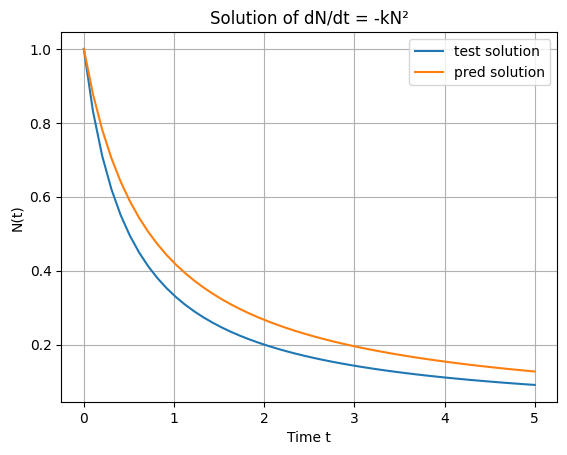

In [53]:
# Parameters
k = 2
N0 = 1

# Time span and evaluation points
t_span = (0, 5)
num_time_points = 50
t_eval = np.linspace(*t_span, num_time_points)

test_solution = analytical_solution(t_eval, N0, k)

test_data = input_scaler.transform(test_solution.reshape(-1, 1)).reshape(1, test_solution.shape[0], 1)
input_tensor = torch.from_numpy(test_data).float().to(device)

# ----------------------------
#     MAKE PREDICTION
# ----------------------------
with torch.no_grad():
    pred_k = model(input_tensor)

pred_k = pred_k.cpu().numpy()
pred_k = output_scaler.inverse_transform(pred_k)[0]
print(pred_k)

pred_solution = analytical_solution(t_eval, N0, pred_k)
# Plotting
plt.plot(t_eval, test_solution, label='test solution')
plt.plot(t_eval, pred_solution, label='pred solution')
plt.xlabel('Time t')
plt.ylabel('N(t)')
plt.title('Solution of dN/dt = -kN²')
plt.grid()
plt.legend()
plt.show()